In [ ]:
# https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews

In [61]:
import numpy as np

In [101]:
import pandas as pd
df = pd.read_csv('singapore_airlines_reviews.csv')

In [102]:
df

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0
...,...,...,...,...,...,...,...
9995,2018-08-06T03:48:21-04:00,Desktop,5,review,First part done with Singapore Airlines - acce...,"Flew to NZ 1st half Singapore Airlines, 2nd ha...",1
9996,2018-08-05T22:50:29-04:00,Mobile,5,review,And again a great Flight with Singapore Air. G...,Best Airline,1
9997,2018-08-05T22:47:06-04:00,Desktop,5,review,"We flew business class from Frankfurt, via Sin...",Superb service on Singapore Airlines,1
9998,2018-08-05T20:32:03-04:00,Desktop,4,review,"As always, the A380 aircraft was spotlessly pr...",A Comfortable Fiight Spoiled by lack of adequa...,2


In [108]:
df['rating'].value_counts()

1    8400
0    1600
Name: rating, dtype: int64

In [104]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = [torch.tensor([vocab[token] for token in tokenizer(text)], dtype=torch.long) for text in texts]  # Tokenize each text
        self.labels = torch.tensor(labels, dtype=torch.float)  # dtype=torch.float for labels if using BCEWithLogitsLoss
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Assuming 'df' is your DataFrame with 'text' and 'rating' columns
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for text in df['text']:
    counter.update(tokenizer(text))
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(df['text']), specials=["<unk>", "<pad>"], min_freq=1)

# Set default index for unknown tokens
vocab.set_default_index(vocab["<unk>"])

# Convert ratings to a binary format for binary classification (0 or 1)
# This could be adjusted based on your specific needs
df['rating'] = (df['rating'] >= 3).astype(int)


train_df, test_df = train_test_split(df, test_size=0.2)


def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        text_list.append(_text)  # These should already be torch.long
        lengths.append(len(_text))
    labels = torch.tensor(label_list, dtype=torch.float)
    texts = pad_sequence(text_list, padding_value=vocab["<pad>"], batch_first=True)  # Ensure batch_first is consistent with your model
    lengths = torch.tensor(lengths)  # Default is torch.int64, which is fine
    return labels, texts, lengths


train_dataset = TextDataset(train_df['text'].tolist(), train_df['rating'].tolist(), vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)


In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        # text: batch_size x seq_len
        embedded = self.embedding(text)  # batch_size x seq_len x embed_dim
        # Pack the sequence for RNN
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # Unpack the sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        # Use the hidden state of the last layer of RNN for classification
        hidden = hidden.squeeze(0)  # batch_size x hidden_dim
        out = self.fc(hidden)  # batch_size x output_dim
        return out, hidden, embedded

In [107]:
import matplotlib.pyplot as plt

model = RNNClassifier(len(vocab), embed_dim=100, hidden_dim=128, output_dim=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Input sequence: my husband and i had a wonderful experience with sia in january 2019 while travelling to munich from singapore with our 1 . 5 years old son ! ! we were hesitated at first due to the cost of the tickets . well , i think we made the right choice especially with baby/toddler . the air stewardess and steward are helpful & friendly . there is one steward named justin , he sang & gave him toys to pacify my cranky boy ! ! oh my , what can i asked for ! ! well done sia ! ! my first choice as always~
Output probability: 0.9986909031867981


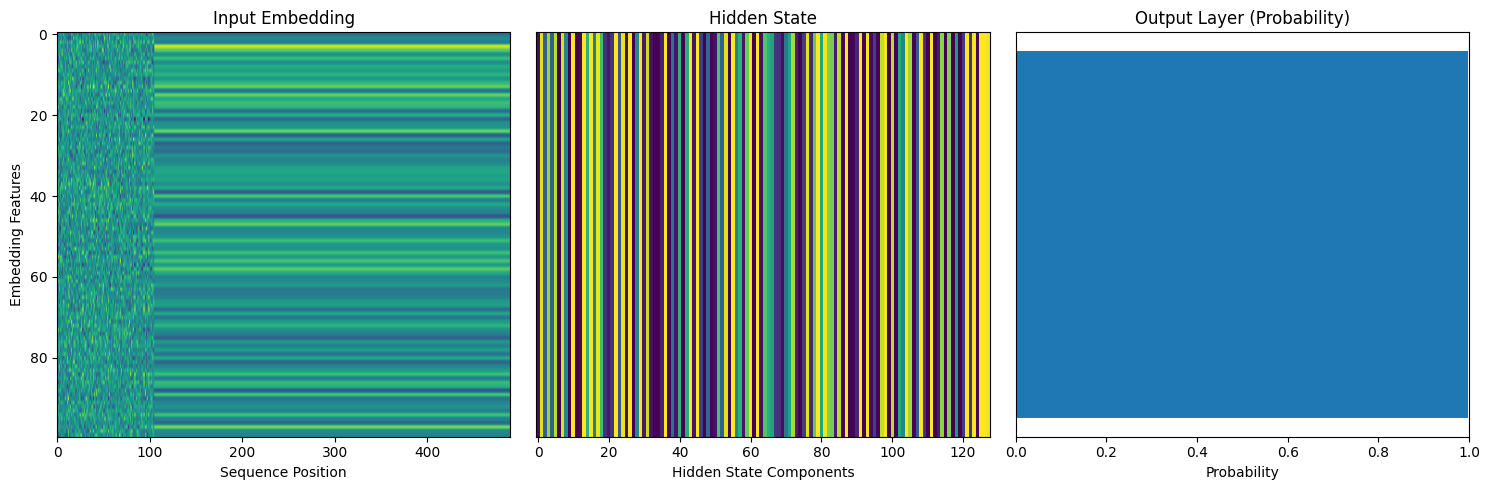

<Figure size 640x480 with 0 Axes>

Epoch: 3, Loss: 0.09641366636008024


In [114]:
from IPython.display import display, clear_output

num_epochs = 3
update_freq = 10  # Update the visualization every 'update_freq' batches

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for i, (labels, texts, lengths) in enumerate(train_loader):
        optimizer.zero_grad()
        output, hidden, embeddings = model(texts, lengths)  # Adjusted to return embeddings
        loss = criterion(output.squeeze(1), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Visualization after each batch, limited by update_freq
        if i % update_freq == 0:
            clear_output(wait=True)
            
            # Filter out <pad> tokens from sequence_tokens
            sequence_tokens = [index_to_token[token.item()] for token in texts[0] if index_to_token[token.item()] != '<pad>']
            print("Input sequence:", " ".join(sequence_tokens))

            # Print the sequence of tokens
            #sequence_tokens = [index_to_token[token.item()] for token in texts[0]]
            #print("Input sequence:", " ".join(sequence_tokens))
            
            # Prepare the data for visualization
            embedding_vis = embeddings[0].detach().numpy().T
            hidden_state_vis = hidden.squeeze(0)[0].detach().numpy().reshape(1, -1)

            # Check and print the output value
            output_val = output[0].detach().item()  # Raw logit
            probability = torch.sigmoid(torch.tensor(output_val)).item()  # Convert logit to probability
            
            hidden_scale = np.max(np.abs(hidden_state_vis))

            #print("Output value (logit):", output_val)
            print("Output probability:", probability)

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

            ax1.imshow(embedding_vis, aspect='auto')
            ax1.set_title('Input Embedding')
            ax1.set_xlabel('Sequence Position')
            ax1.set_ylabel('Embedding Features')

            ax2.imshow(hidden_state_vis, aspect='auto', vmin=-hidden_scale, vmax=hidden_scale)
            ax2.set_title('Hidden State')
            ax2.set_xlabel('Hidden State Components')
            ax2.set_yticks([])
            
            # Adjusting the visualization based on the output range
            ax3.barh([0], probability, height=0.5)
            ax3.set_xlim(0, 1)  # Probability range
            ax3.set_title('Output Layer (Probability)')
            ax3.set_yticks([])
            ax3.set_xlabel('Probability')

            plt.tight_layout()
            plt.show()
            display(plt.gcf())
            plt.close()

    print(f'Epoch: {epoch + 1}, Loss: {total_loss / len(train_loader)}')


Input Sequence:

**The input sequence** is printed as a series of tokens extracted from the input text. <pad> tokens are filtered out to improve readability. This sequence represents the words or tokens in the input text being processed by the model.

**Input Embedding:**
The leftmost subplot (ax1) displays the input embedding matrix.
Each row represents a token in the input sequence, and each column represents a feature in the embedding space.
This visualization helps in understanding how the model represents each token in the embedding space, capturing semantic and contextual information.

**Hidden State:**
The middle subplot (ax2) visualizes the hidden state of the RNN.
Each row represents a hidden state component, and each column represents a time step in the sequence.
The colors represent the magnitude of the hidden state components, where brighter colors indicate higher values and darker colors indicate lower values.
By observing the hidden state over time, you can understand how the model's internal representation evolves as it processes the input sequence.

**Output Layer (Probability):**
The rightmost subplot (ax3) displays the output probability.
It represents the probability of the output class, which is typically obtained by applying a sigmoid activation function to the output logits.
The horizontal bar indicates the probability value, with the scale ranging from 0 to 1.
This visualization provides insight into the model's confidence in predicting the output class.
